<a href="https://colab.research.google.com/github/Katharina-github/Data-Cleaning-Pipeline/blob/main/Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and data load

In [1]:
# Imports
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import numpy as np


In [2]:
#Loading the data from personal device
from google.colab import files

uploaded = files.upload()

Saving gamezone-orders-data.csv to gamezone-orders-data.csv
Saving gamezone-orders-data-regions.csv to gamezone-orders-data-regions.csv


In [24]:
# Load data as dataframe
orders_df = pd.read_csv('gamezone-orders-data.csv',
    sep=';',               # use semicolons as the delimiter
    dtype={'USER_ID': str}, # keep USER_IDs as strings
    na_values=['NULL', ''],          # treat the string "NULL" and empty strings as NaN
    keep_default_na=True,            # still use pandas’ other default missing markers
    engine='python'        # more flexible parser for unusual formats
)
regions_df = pd.read_csv('gamezone-orders-data-regions.csv')

In [25]:
orders_df.head()

,USER_ID,ORDER_ID,PURCHASE_TS,SHIP_TS,PRODUCT_NAME,PRODUCT_ID,USD_PRICE,PURCHASE_PLATFORM,MARKETING_CHANNEL,ACCOUNT_CREATION_METHOD,COUNTRY_CODE
0,2c06175e,0001328c3c220830,24.12.2020,13.12.2020,Nintendo Switch,e682,168.00,website,affiliate,unknown,US
1,ee8e5bc2,0002af7a5c6100772,01.10.2020,21.09.2020,Nintendo Switch,e682,160.61,website,direct,desktop,DE
2,9eb4efe0,0002b8350e167074,21.04.2020,16.02.2020,Nintendo Switch,8d0d,151.20,website,direct,desktop,US
3,cac7cbaf,0006d06b98385729,07.04.2020,04.04.2020,Sony PlayStation 5 Bundle,54ed,1132.82,website,direct,desktop,AU
4,6b0230bc,00097279a2f46150,24.11.2020,02.08.2020,Nintendo Switch,8d0d,33.89,website,direct,desktop,TR


# EDA (to estimatate right imputation or indicator strategy)

In [26]:
miss = orders_df.isna()

In [27]:
# adding prices with 0 or negative value as error (in this case there are no refunds recorded in this data)
price_error = (orders_df['USD_PRICE'] <= 0)  # zero or negative

In [28]:
error_mask = pd.concat([
    orders_df.isna().rename(columns=lambda c: f"{c}_na"),
    price_error.rename("USD_PRICE_error")
], axis=1)

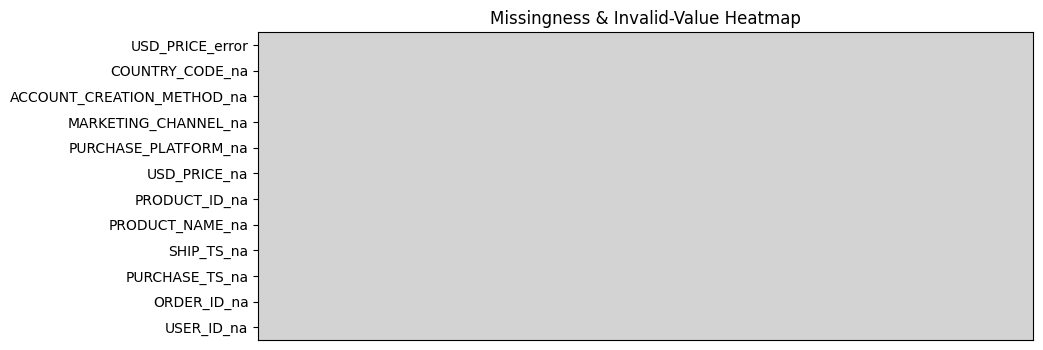

In [29]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(error_mask.T, edgecolors='lightgray', linewidth=0.2)
plt.yticks(np.arange(0.5, len(error_mask.columns), 1), error_mask.columns)
plt.xticks([])
plt.title("Missingness & Invalid‐Value Heatmap")
plt.show()

ACCOUNT_CREATION_METHOD    0.003796
MARKETING_CHANNEL          0.003796
COUNTRY_CODE               0.001738
USD_PRICE                  0.001555
PURCHASE_TS                0.000046
ORDER_ID                   0.000000
USER_ID                    0.000000
PRODUCT_ID                 0.000000
PRODUCT_NAME               0.000000
SHIP_TS                    0.000000
PURCHASE_PLATFORM          0.000000
dtype: float64


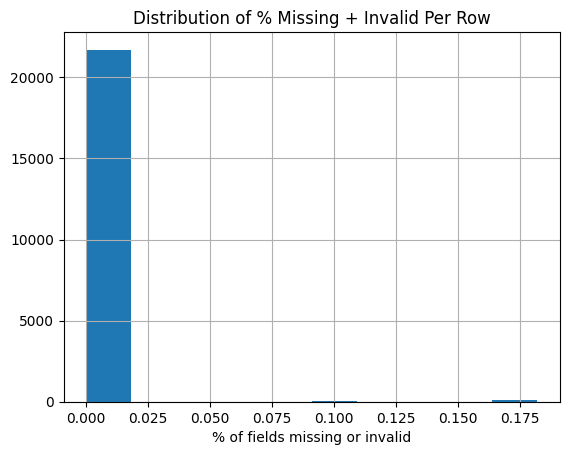

In [30]:
# 1) Define your invalid‐value condition(s): USD_PRICE <= 0 is “invalid”
price_invalid = orders_df['USD_PRICE'] <= 0

# 2) Build a combined mask: True if NA _or_ invalid
combined_mask = orders_df.isna()
combined_mask['USD_PRICE'] = combined_mask['USD_PRICE'] | price_invalid

# 3) % “bad” per column (missing + invalid)
bad_rate_col = combined_mask.mean().sort_values(ascending=False)
print(bad_rate_col)

# 4) % “bad” per row
orders_df['pct_bad'] = combined_mask.mean(axis=1)
orders_df['pct_bad'].hist(bins=10)
plt.title("Distribution of % Missing + Invalid Per Row")
plt.xlabel("% of fields missing or invalid")
plt.show()

In [31]:
# Explicitly parse date columns before calculating lag_days
date_cols_to_parse = ['PURCHASE_TS', 'SHIP_TS']
for col in date_cols_to_parse:
    orders_df[col] = pd.to_datetime(orders_df[col], format="%d.%m.%Y", errors='coerce')

# Compute delivery lag in days
orders_df['lag_days'] = (orders_df['SHIP_TS'] - orders_df['PURCHASE_TS']).dt.days

# How many are negative?
negatives = (orders_df['lag_days'] < 0).sum()
total     = len(orders_df)
print(f"{negatives} orders ({negatives/total:.1%}) have ship dates before purchase dates.")

2000 orders (9.1%) have ship dates before purchase dates.


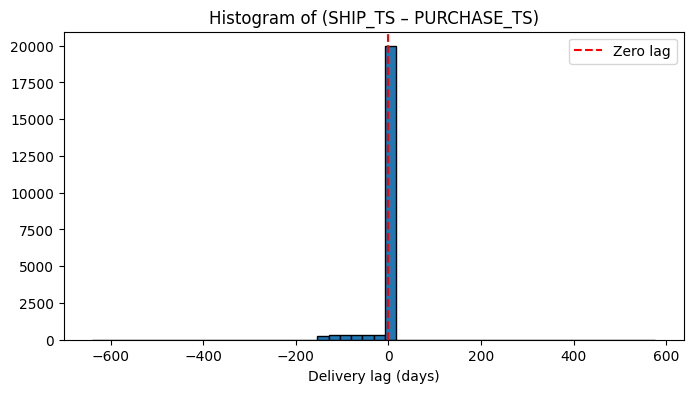

In [32]:
plt.figure(figsize=(8,4))
# Histogram showing negative vs. positive lags
plt.hist(orders_df['lag_days'], bins=50, edgecolor='k')
plt.axvline(0, color='r', linestyle='--', label='Zero lag')
plt.legend()
plt.xlabel("Delivery lag (days)")
plt.title("Histogram of (SHIP_TS – PURCHASE_TS)")
plt.show()

Looking for patterns by key features

In [33]:
# Rate of negative-lag orders per country
rate_by_country = (
    orders_df.assign(is_negative = orders_df['lag_days'] < 0)
             .groupby('COUNTRY_CODE')['is_negative']
             .mean()
             .sort_values(ascending=False)
)
print(rate_by_country)


COUNTRY_CODE
AD    0.500000
SN    0.500000
PF    0.500000
CI    0.333333
HT    0.333333
        ...   
VC    0.000000
VI    0.000000
VU    0.000000
ZM    0.000000
ZW    0.000000
Name: is_negative, Length: 150, dtype: float64


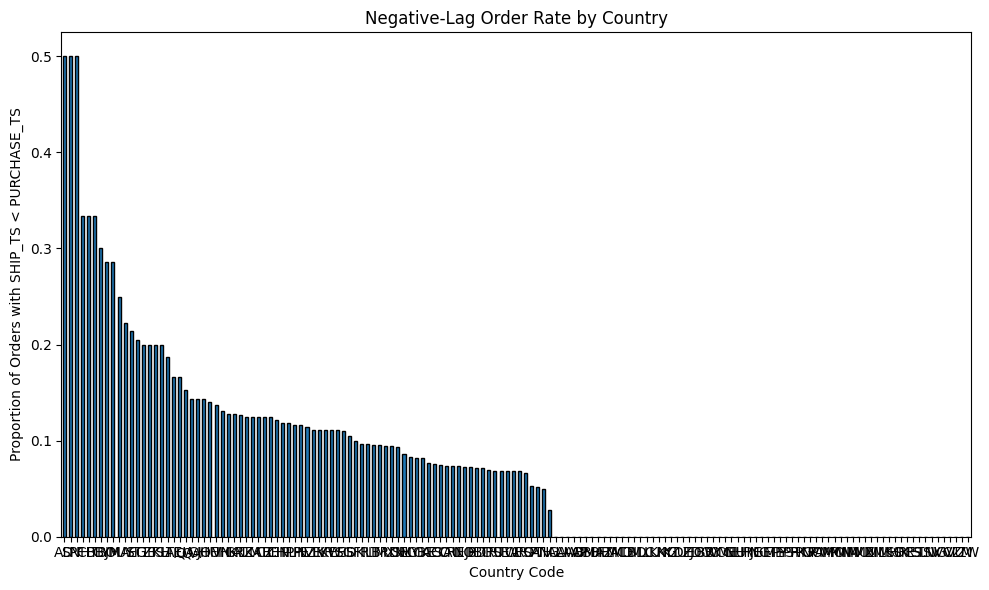

In [34]:
# 1. Create a boolean flag for negative lags
orders_df['is_negative'] = (orders_df['lag_days'] < 0)

# 2. Compute the share of negative‐lag orders per country
rate_by_country = (
    orders_df
    .groupby('COUNTRY_CODE')['is_negative']
    .mean()
    .sort_values(ascending=False)
)

# 3. Plot as a bar chart
plt.figure(figsize=(10, 6))
rate_by_country.plot(kind='bar', edgecolor='k')
plt.ylabel('Proportion of Orders with SHIP_TS < PURCHASE_TS')
plt.xlabel('Country Code')
plt.title('Negative‐Lag Order Rate by Country')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

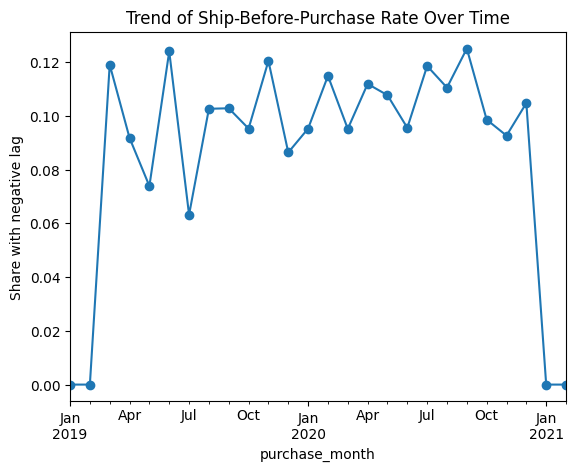

In [35]:
# Add a purchase-month column
orders_df['purchase_month'] = orders_df['PURCHASE_TS'].dt.to_period('M')

# Negative‐lag rate by month
monthly_rate = (
    orders_df.assign(is_negative = orders_df['lag_days'] < 0)
             .groupby('purchase_month')['is_negative']
             .mean()
)
monthly_rate.plot(marker='o')
plt.ylabel("Share with negative lag")
plt.title("Trend of Ship-Before-Purchase Rate Over Time")
plt.show()


No patterns in time_to_ship detected

# Pipeline blocks

In [37]:
class DateParserTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to parse specified columns to datetime using pandas.to_datetime.

    Parameters
    ----------
    cols : list of str
        List of column names to convert.
    fmt : str or None
        Optional datetime format string (passed to pd.to_datetime).
        If None, pandas will infer the format.
    errors : {'raise', 'coerce', 'ignore'}, default='raise'
        How to handle parsing errors.
    """

    def __init__(self, cols, fmt=None, errors='coerce'):
        self.cols = cols
        self.fmt  = fmt
        self.errors = errors

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        self.stats_ = {}
        for col in self.cols:
            before_na = X[col].isna().sum()
            parsed = pd.to_datetime(X[col], format=self.fmt, errors=self.errors)
            after_na  = parsed.isna().sum()
            self.stats_[col] = {
                'parsed_to_dt': X.shape[0] - before_na - (X.shape[0] - after_na),
                'new_nats': after_na - before_na
            }
            X[col] = parsed
        return X

In [38]:
class DateImputerTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to impute or drop missing datetime values (NaT) in specified columns.

    Parameters
    ----------
    cols : list of str
        List of datetime column names to process.
    strategy : {'constant', 'median', 'forward_fill', 'drop'}
        - 'constant': fill with the given `fill_value` (a pd.Timestamp).
        - 'median': compute median of non-missing dates and fill with that.
        - 'forward_fill': propagate last valid observation forward.
        - 'drop': drop any row where the column is NaT.
    fill_value : pd.Timestamp or None, default=pd.Timestamp('1970-01-01')
        Used when strategy='constant'.
    """
    def __init__(self, cols, strategy='constant', fill_value=None):
        self.cols = cols
        self.strategy = strategy
        self.fill_value = fill_value if fill_value is not None else pd.Timestamp('1970-01-01')

    def fit(self, X, y=None):
        X = X.copy()
        # Precompute medians for 'median' strategy
        self.medians_ = {}
        if self.strategy == 'median':
            for col in self.cols:
                non_null = X[col].dropna().sort_values()
                if not non_null.empty:
                    self.medians_[col] = non_null.iloc[len(non_null) // 2]
                else:
                    self.medians_[col] = self.fill_value
        return self

    def transform(self, X):
        X = X.copy()
        self.stats_ = {}
        for col in self.cols:
            before_na = X[col].isna().sum()
            if self.strategy == 'constant':
                X[col] = X[col].fillna(self.fill_value)
            elif self.strategy == 'median':
                X[col] = X[col].fillna(self.medians_[col])
            elif self.strategy == 'forward_fill':
                X[col] = X[col].fillna(method='ffill')
            elif self.strategy == 'drop':
                X = X.dropna(subset=[col])
            else:
                raise ValueError(f"Unknown strategy: {self.strategy}")
            after_na = X[col].isna().sum() if self.strategy != 'drop' else 0
            dropped = before_na if self.strategy == 'drop' else 0
            imputed = before_na - after_na
            self.stats_[col] = {
                'before_na': before_na,
                'after_na': after_na,
                'imputed_count': imputed,
                'dropped_count': dropped
            }
        return X

In [40]:
class CategoricalImputerTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to handle missing categorical values.

    Parameters
    ----------
    cols : list of str
      Columns to impute.
    strategy : {'constant', 'drop'}
      - 'constant': fill missing with `fill_value`.
      - 'drop': drop any row with missing in these cols.
    fill_value : str, default='unknown'
      Value to use when strategy='constant'.
    """
    def __init__(self, cols, strategy='constant', fill_value='unknown'):
        self.cols       = cols
        self.strategy   = strategy
        self.fill_value = fill_value

    def fit(self, X, y=None):
        # nothing to learn, but record initial missing counts
        mask = X[self.cols].isna()
        self.initial_missing_ = mask.sum().to_dict()
        return self

    def transform(self, X):
        X = X.copy()
        # fill or drop
        if self.strategy == 'constant':
            for col in self.cols:
                X[col] = X[col].fillna(self.fill_value)
        elif self.strategy == 'drop':
            X = X.dropna(subset=self.cols)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")

        # record how many are missing after
        mask = X[self.cols].isna()
        self.post_missing_ = mask.sum().to_dict()
        return X

    def get_stats(self):
        """
        Returns a dict per-column of (before, after) missing counts.
        """
        stats = {}
        for col in self.cols:
            before = self.initial_missing_.get(col, 0)
            after  = self.post_missing_.get(col, 0)
            stats[col] = {'missing_before': before, 'missing_after': after}
        return stats

In [44]:
class DuplicateRemoverTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, subset, keep='first'):
        self.subset = subset
        self.keep   = keep

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        before = len(X)
        X = X.loc[~X.duplicated(subset=self.subset, keep=self.keep)].reset_index(drop=True)
        after = len(X)
        self.stats_ = {'dropped': before - after}
        return X

So far not adressed cleaning issues:
Missing:
InvalidValueIndicator (optional)
– Flags rows where numeric columns (e.g. USD_PRICE) were zero/negative as a new binary feature.

MissingImputerTransformer
– For purely numeric columns (like USD_PRICE), imputes missing values (median, mean, or custom).

CategoricalEncoderTransformer
– One-hot (or ordinal, target) encodes your categorical features (PRODUCT_NAME, MARKETING_CHANNEL, etc.).

ScalerTransformer
– Standard-scales (or MinMax-scales) numeric features so they’re ready for models (especially if you’ll cluster or fit regressions).

FeatureEngineer_LagRolling

missing country code

order_id duplicate

Rename "27inches 4K gaming monitor” to
"27in 4k gaming monitor”

set invalid region values (Empty, X.x) to unknown

Region NA is not defined (NA stands for North America or Caribbean and outlying territories?))

join region / country code, what to do with missing matches

ship for ordering date - in relevant analyses (switch values for short differnces) big differences?


# End-to-End Pipeline Demo

In [45]:
date_cols = ['PURCHASE_TS', 'SHIP_TS']
cat_cols = ['PURCHASE_PLATFORM', 'MARKETING_CHANNEL', 'ACCOUNT_CREATION_METHOD']


pipeline = Pipeline([
    ('date_parser', DateParserTransformer(cols=date_cols, fmt='%d.%m.%Y', errors='coerce')),
    ('date_imputer', DateImputerTransformer(cols=date_cols, strategy='drop')),
    ('remove_dupes', DuplicateRemoverTransformer(subset=['USER_ID','ORDER_ID','PURCHASE_TS','PRODUCT_ID'])),
    ('cat_imputer', CategoricalImputerTransformer(cols=cat_cols, strategy='constant', fill_value='unknown'))
 ])
parsed_df = pipeline.fit_transform(orders_df)

# After fitting, inspect stats:
for name, step in pipeline.named_steps.items():
    if hasattr(step, 'stats_'):
        print(f"\n>>> {name} stats_:\n", step.stats_)
    if hasattr(step, 'get_stats'):
        print(f"\n>>> {name} get_stats():\n", step.get_stats())
    if hasattr(step, 'initial_missing_') and hasattr(step, 'post_missing_'):
        before = step.initial_missing_
        after  = step.post_missing_
        print(f"\n>>> {name} missing counts before→after:\n", dict(zip(before.keys(), zip(before.values(), after.values()))))


>>> date_parser stats_:
 {'PURCHASE_TS': {'parsed_to_dt': np.int64(0), 'new_nats': np.int64(0)}, 'SHIP_TS': {'parsed_to_dt': np.int64(0), 'new_nats': np.int64(0)}}

>>> date_imputer stats_:
 {'PURCHASE_TS': {'before_na': np.int64(1), 'after_na': 0, 'imputed_count': np.int64(1), 'dropped_count': np.int64(1)}, 'SHIP_TS': {'before_na': np.int64(0), 'after_na': 0, 'imputed_count': np.int64(0), 'dropped_count': np.int64(0)}}

>>> remove_dupes stats_:
 {'dropped': 39}

>>> cat_imputer get_stats():
 {'PURCHASE_PLATFORM': {'missing_before': 0, 'missing_after': 0}, 'MARKETING_CHANNEL': {'missing_before': 83, 'missing_after': 0}, 'ACCOUNT_CREATION_METHOD': {'missing_before': 83, 'missing_after': 0}}

>>> cat_imputer missing counts before→after:
 {'PURCHASE_PLATFORM': (0, 0), 'MARKETING_CHANNEL': (83, 0), 'ACCOUNT_CREATION_METHOD': (83, 0)}


In [ ]:
print(parsed_df.dtypes)
print(parsed_df.head())

USER_ID                            object
ORDER_ID                           object
PURCHASE_TS                datetime64[ns]
SHIP_TS                    datetime64[ns]
PRODUCT_NAME                       object
PRODUCT_ID                         object
USD_PRICE                         float64
PURCHASE_PLATFORM                  object
MARKETING_CHANNEL                  object
ACCOUNT_CREATION_METHOD            object
COUNTRY_CODE                       object
dtype: object
    USER_ID           ORDER_ID PURCHASE_TS    SHIP_TS  \
0  2c06175e   0001328c3c220830  2020-12-24 2020-12-13   
1  ee8e5bc2  0002af7a5c6100772  2020-10-01 2020-09-21   
2  9eb4efe0   0002b8350e167074  2020-04-21 2020-02-16   
3  cac7cbaf   0006d06b98385729  2020-04-07 2020-04-04   
4  6b0230bc   00097279a2f46150  2020-11-24 2020-08-02   

                PRODUCT_NAME PRODUCT_ID  USD_PRICE PURCHASE_PLATFORM  \
0            Nintendo Switch       e682     168.00           website   
1            Nintendo Switch       e6